In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
)
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC

## Dataset info

### Original dataset

- No. instances: 253680
- Class balances
    - Label 0 — 218334 (86%)
    - Label 1 — 35346 (14%)
- No. features: 21 features
    - Real valued features, 1
        - BMI — 84 distinct values
    - Volatile features, 3
        - Age — 13 distinct values
        - Mental health — 31 distinct values
        - Physical health — 31 distinct values
    - Categorical features, 17

### Processed dataset

- Procedure
    - Removed 5 features: Fruits, Veggies, Sex, CholCheck, AnyHealthcare
    - Scale real valued + volatile features (4 in total)
    - Covert categorical features to one hot encodings
- No. features: 34 features
    - Real valued features, 4
    - Binary features: 28
- Train data: 177576 (70%) (152834 - 24742)
- Hold out test: 76104 (30%) (65500 - 10604)

In [2]:
# We load from pre-processed data

train_npz = np.load("/data/public/cdc/train_cdc.npz", "r")
train_X = train_npz["X"]
train_y = train_npz["y"]

test_npz = np.load("/data/public/cdc/hold_out_test_cdc.npz", "r")
hold_out_test_X = test_npz["X"]
hold_out_test_y = test_npz["y"]

print("Train shape: ", train_X.shape)
print("Test shape: ", hold_out_test_X.shape)


Train shape:  (177576, 32)
Test shape:  (76104, 32)


In [3]:
# show class distribution
unique, counts = np.unique(train_y, return_counts=True)
print("Train class distribution: ", dict(zip(unique, counts)))
unique, counts = np.unique(hold_out_test_y, return_counts=True)
print("Test class distribution: ", dict(zip(unique, counts)))


Train class distribution:  {0: 152834, 1: 24742}
Test class distribution:  {0: 65500, 1: 10604}


### Common code

In [4]:
# Config
NUM_FOLD = 5
RANDOM_STATE = 73

In [5]:
def get_fold_print_string(fold_result: list[float]):
    mean = np.mean(fold_result)
    ste = np.std(fold_result) / np.sqrt(NUM_FOLD)
    return f"{mean:.3f} ± {ste:.3f}"

In [6]:
def binary_classification(
    model,
    model_name: str,
    n_splits: int = NUM_FOLD,
    random_state: int = RANDOM_STATE,
):
    print(f"Model {model_name} with {n_splits}-fold cross-validation\n")
    skf = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=random_state
    )

    fold_accuracy = []
    fold_precision = []
    fold_recall = []
    fold_f1 = []
    fold_mcc = []

    hold_out_accuracy = []
    hold_out_precision = []
    hold_out_recall = []
    hold_out_f1 = []
    hold_out_mcc = []

    fig, ax = plt.subplots(1, 5, figsize=(15, 4))
    for i, (train_index, test_index) in enumerate(skf.split(train_X, train_y)):
        model.fit(train_X[train_index], train_y[train_index])

        y_pred = model.predict(train_X[test_index])

        acc = accuracy_score(train_y[test_index], y_pred)
        prec = precision_score(train_y[test_index], y_pred, zero_division=0)
        rec = recall_score(train_y[test_index], y_pred)
        f1 = f1_score(train_y[test_index], y_pred)
        mcc = matthews_corrcoef(train_y[test_index], y_pred)
        fold_accuracy.append(acc)
        fold_precision.append(prec)
        fold_recall.append(rec)
        fold_f1.append(f1)
        fold_mcc.append(mcc)
        print(
            f"Fold {i}: Accuracy={acc:.4f}, Precision={prec:.4f}, "
            f"Recall={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}"
        )

        # Test on hold-out test set
        y_hold_out_pred = model.predict(hold_out_test_X)

        acc = accuracy_score(hold_out_test_y, y_hold_out_pred)
        prec = precision_score(
            hold_out_test_y, y_hold_out_pred, zero_division=0
        )
        rec = recall_score(hold_out_test_y, y_hold_out_pred)
        f1 = f1_score(hold_out_test_y, y_hold_out_pred)
        mcc = matthews_corrcoef(hold_out_test_y, y_hold_out_pred)
        hold_out_accuracy.append(acc)
        hold_out_precision.append(prec)
        hold_out_recall.append(rec)
        hold_out_f1.append(f1)
        hold_out_mcc.append(mcc)
        print(
            f"Hold-out Test: Accuracy={acc:.4f}, Precision={prec:.4f}, "
            f"Recall={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}"
        )

        # Plot confusion matrix
        cm = confusion_matrix(train_y[test_index], y_pred)
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=model.classes_
        )
        disp.plot(ax=ax[i], xticks_rotation=45)
        ax[i].set_title(f"Fold {i}")

    print("\nCross-Validation Results:")
    print(f"Mean Accuracy: {get_fold_print_string(fold_accuracy)}")
    print(f"Mean Precision: {get_fold_print_string(fold_precision)}")
    print(f"Mean Recall: {get_fold_print_string(fold_recall)}")
    print(f"Mean F1 Score: {get_fold_print_string(fold_f1)}")
    print(f"Mean MCC: {get_fold_print_string(fold_mcc)}")

    print("\nHold-out Test Results:")
    print(f"Mean Accuracy: {get_fold_print_string(hold_out_accuracy)}")
    print(f"Mean Precision: {get_fold_print_string(hold_out_precision)}")
    print(f"Mean Recall: {get_fold_print_string(hold_out_recall)}")
    print(f"Mean F1 Score: {get_fold_print_string(hold_out_f1)}")
    print(f"Mean MCC: {get_fold_print_string(hold_out_mcc)}")

    plt.tight_layout()

## Logistic regression

Model Logistic Regression with 5-fold cross-validation

Fold 0: Accuracy=0.8630, Precision=0.5300, Recall=0.1481, F1=0.2315, MCC=0.2271
Hold-out Test: Accuracy=0.8642, Precision=0.5474, Recall=0.1465, F1=0.2312, MCC=0.2319
Fold 1: Accuracy=0.8637, Precision=0.5440, Recall=0.1362, F1=0.2179, MCC=0.2222
Hold-out Test: Accuracy=0.8642, Precision=0.5482, Recall=0.1427, F1=0.2264, MCC=0.2290
Fold 2: Accuracy=0.8636, Precision=0.5388, Recall=0.1431, F1=0.2261, MCC=0.2261
Hold-out Test: Accuracy=0.8643, Precision=0.5506, Recall=0.1432, F1=0.2273, MCC=0.2303
Fold 3: Accuracy=0.8626, Precision=0.5257, Recall=0.1445, F1=0.2267, MCC=0.2227
Hold-out Test: Accuracy=0.8639, Precision=0.5445, Recall=0.1437, F1=0.2274, MCC=0.2286
Fold 4: Accuracy=0.8635, Precision=0.5393, Recall=0.1400, F1=0.2223, MCC=0.2238
Hold-out Test: Accuracy=0.8643, Precision=0.5495, Recall=0.1435, F1=0.2276, MCC=0.2302

Cross-Validation Results:
Mean Accuracy: 0.863 ± 0.000
Mean Precision: 0.536 ± 0.003
Mean Recall: 0.142 ± 0.

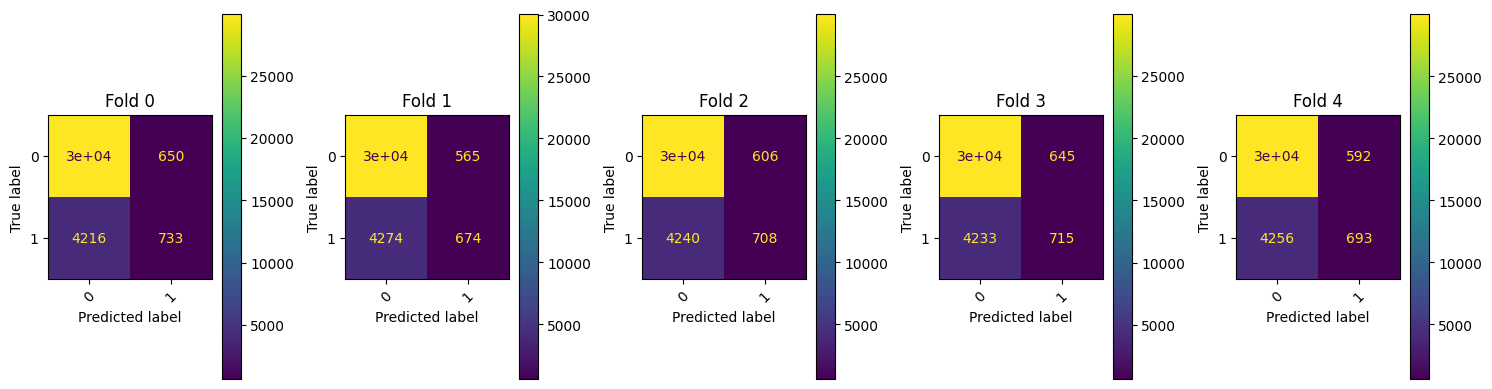

In [7]:
model = LogisticRegression(solver="liblinear")
binary_classification(model, "Logistic Regression")

## Random forest

Model Random Forest with 5-fold cross-validation

Fold 0: Accuracy=0.8532, Precision=0.4376, Recall=0.1869, F1=0.2619, MCC=0.2166
Hold-out Test: Accuracy=0.8549, Precision=0.4501, Recall=0.1875, F1=0.2647, MCC=0.2227
Fold 1: Accuracy=0.8537, Precision=0.4373, Recall=0.1754, F1=0.2504, MCC=0.2094
Hold-out Test: Accuracy=0.8542, Precision=0.4427, Recall=0.1796, F1=0.2556, MCC=0.2145
Fold 2: Accuracy=0.8556, Precision=0.4543, Recall=0.1819, F1=0.2598, MCC=0.2211
Hold-out Test: Accuracy=0.8550, Precision=0.4492, Recall=0.1807, F1=0.2577, MCC=0.2181
Fold 3: Accuracy=0.8552, Precision=0.4534, Recall=0.1906, F1=0.2684, MCC=0.2262
Hold-out Test: Accuracy=0.8545, Precision=0.4456, Recall=0.1819, F1=0.2584, MCC=0.2172
Fold 4: Accuracy=0.8565, Precision=0.4625, Recall=0.1821, F1=0.2613, MCC=0.2248
Hold-out Test: Accuracy=0.8542, Precision=0.4438, Recall=0.1828, F1=0.2589, MCC=0.2169

Cross-Validation Results:
Mean Accuracy: 0.855 ± 0.001
Mean Precision: 0.449 ± 0.004
Mean Recall: 0.183 ± 0.002
Me

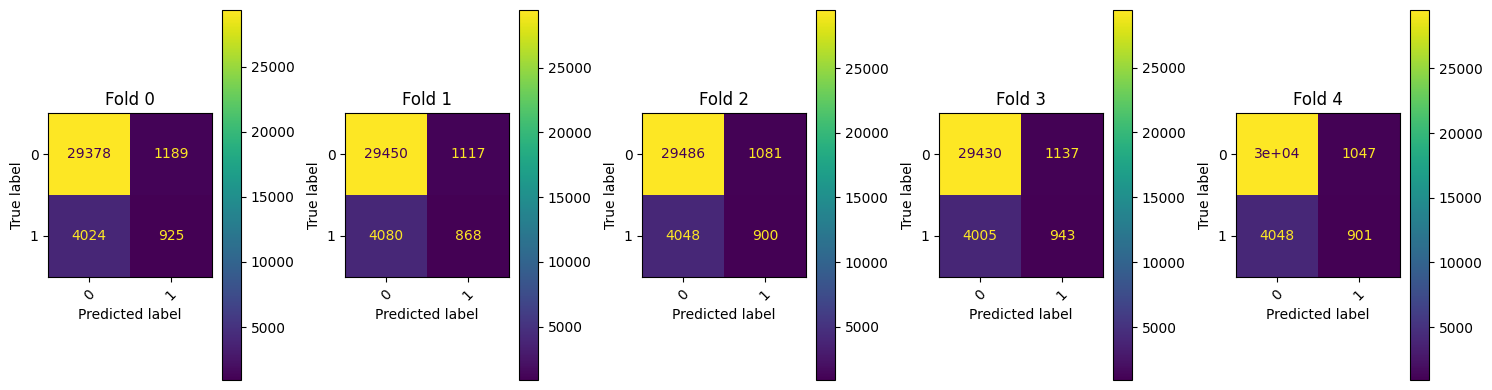

In [8]:
model = RandomForestClassifier(n_estimators=100, random_state=75)
binary_classification(model, "Random Forest")

## SVM

Model SVM with 5-fold cross-validation

Fold 0: Accuracy=0.7209, Precision=0.3047, Recall=0.7820, F1=0.4385, MCC=0.3562
Hold-out Test: Accuracy=0.7249, Precision=0.3065, Recall=0.7722, F1=0.4389, MCC=0.3551
Fold 1: Accuracy=0.7258, Precision=0.3072, Recall=0.7714, F1=0.4394, MCC=0.3557
Hold-out Test: Accuracy=0.7260, Precision=0.3073, Recall=0.7705, F1=0.4393, MCC=0.3554
Fold 2: Accuracy=0.7279, Precision=0.3085, Recall=0.7682, F1=0.4403, MCC=0.3561
Hold-out Test: Accuracy=0.7255, Precision=0.3067, Recall=0.7696, F1=0.4386, MCC=0.3544
Fold 3: Accuracy=0.7222, Precision=0.3043, Recall=0.7726, F1=0.4366, MCC=0.3525
Hold-out Test: Accuracy=0.7246, Precision=0.3062, Recall=0.7712, F1=0.4383, MCC=0.3543
Fold 4: Accuracy=0.7275, Precision=0.3089, Recall=0.7721, F1=0.4412, MCC=0.3579
Hold-out Test: Accuracy=0.7256, Precision=0.3069, Recall=0.7706, F1=0.4390, MCC=0.3550

Cross-Validation Results:
Mean Accuracy: 0.725 ± 0.001
Mean Precision: 0.307 ± 0.001
Mean Recall: 0.773 ± 0.002
Mean F1 Scor

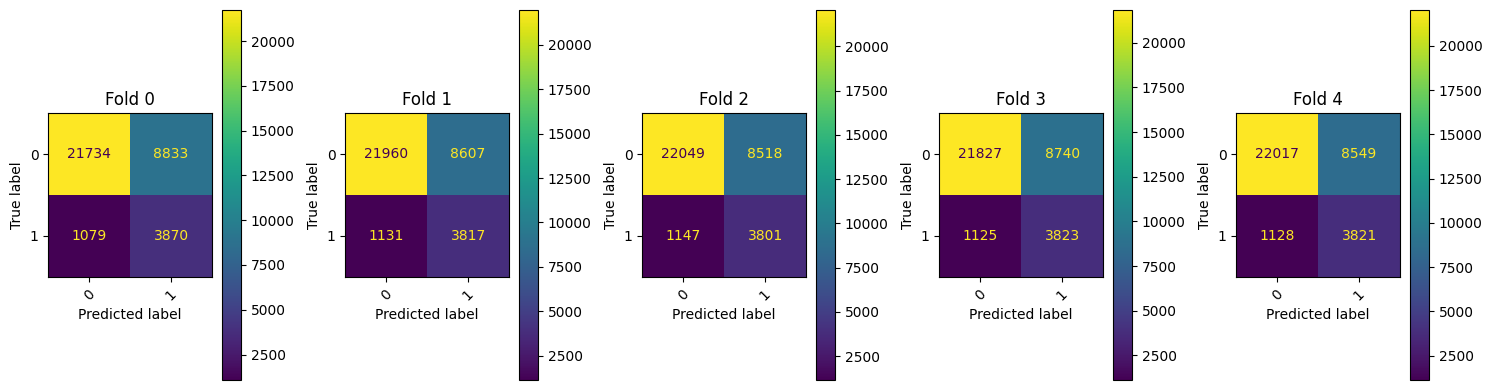

In [9]:
model = LinearSVC(random_state=76, class_weight="balanced")
binary_classification(model, "SVM")

## Decision tree

In [10]:
# Function to calculate the average depth of the decision tree
def average_tree_depth(tree):
    def _recursive_depth(node, current_depth, depths):
        if (
            tree.children_left[node] == tree.children_right[node]
        ):  # It's a leaf node
            depths.append(current_depth)
            return
        _recursive_depth(tree.children_left[node], current_depth + 1, depths)
        _recursive_depth(tree.children_right[node], current_depth + 1, depths)

    depths = []
    _recursive_depth(0, 0, depths)  # Start from the root node (index 0)
    return sum(depths) / len(depths)


# Function to count the number of branches (internal nodes)
def count_branches(tree):
    n_nodes = tree.node_count  # Total number of nodes in the tree
    n_leaves = tree.n_leaves  # Total number of leaf nodes
    n_branches = n_nodes - n_leaves  # Number of internal nodes (branches)
    return n_branches

Decision tree with 5-fold cross-validation

Fold 0: Accuracy=0.7937, Precision=0.2789, Recall=0.3031, F1=0.2905, MCC=0.1702
Hold-out Test: Accuracy=0.7950, Precision=0.2803, Recall=0.3007, F1=0.2901, MCC=0.1706
Fold 1: Accuracy=0.7941, Precision=0.2882, Recall=0.3250, F1=0.3055, MCC=0.1856
Hold-out Test: Accuracy=0.7909, Precision=0.2842, Recall=0.3296, F1=0.3052, MCC=0.1837
Fold 2: Accuracy=0.7878, Precision=0.2682, Recall=0.3027, F1=0.2844, MCC=0.1608
Hold-out Test: Accuracy=0.7912, Precision=0.2819, Recall=0.3220, F1=0.3006, MCC=0.1791
Fold 3: Accuracy=0.7878, Precision=0.2693, Recall=0.3056, F1=0.2863, MCC=0.1627
Hold-out Test: Accuracy=0.7892, Precision=0.2750, Recall=0.3137, F1=0.2931, MCC=0.1703
Fold 4: Accuracy=0.7884, Precision=0.2726, Recall=0.3108, F1=0.2905, MCC=0.1673
Hold-out Test: Accuracy=0.7905, Precision=0.2770, Recall=0.3130, F1=0.2939, MCC=0.1719

Cross-Validation Results:
Mean Accuracy: 0.790 ± 0.001
Mean Precision: 0.275 ± 0.003
Mean Recall: 0.309 ± 0.004
Mean F1 

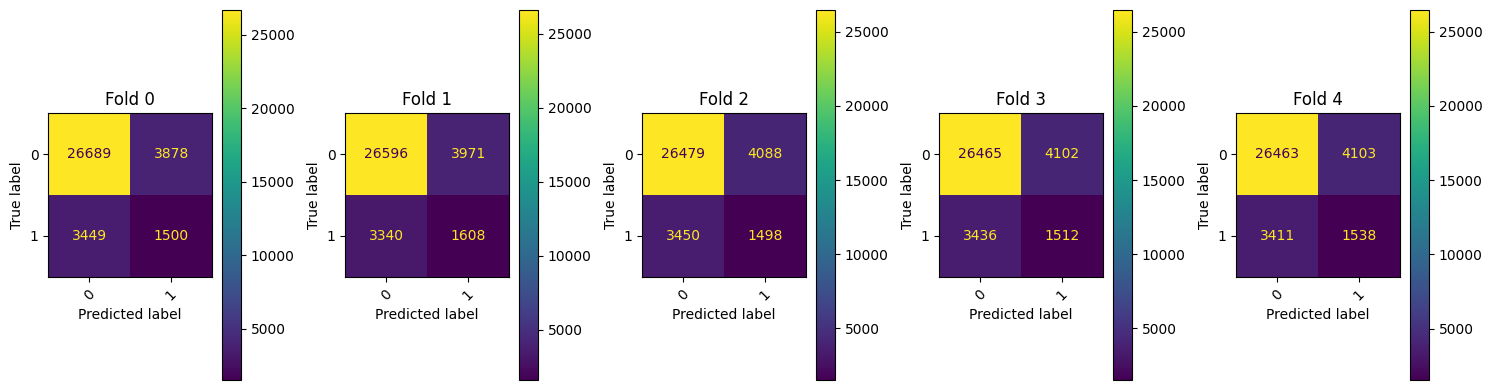

In [11]:
model = DecisionTreeClassifier(random_state=77, class_weight="balanced")
print(f"Decision tree with {NUM_FOLD}-fold cross-validation\n")
skf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=77)

fold_accuracy = []
fold_precision = []
fold_recall = []
fold_f1 = []
fold_mcc = []
tree_stats: list[dict[str, float]] = []
hold_out_accuracy = []
hold_out_precision = []
hold_out_recall = []
hold_out_f1 = []
hold_out_mcc = []

fig, ax = plt.subplots(1, NUM_FOLD, figsize=(15, 4))
for i, (train_index, test_index) in enumerate(skf.split(train_X, train_y)):
    model.fit(train_X[train_index], train_y[train_index])

    y_pred = model.predict(train_X[test_index])

    acc = accuracy_score(train_y[test_index], y_pred)
    prec = precision_score(train_y[test_index], y_pred, zero_division=0)
    rec = recall_score(train_y[test_index], y_pred)
    f1 = f1_score(train_y[test_index], y_pred)
    mcc = matthews_corrcoef(train_y[test_index], y_pred)
    max_depth = model.get_depth()
    avg_depth = average_tree_depth(model.tree_)
    n_branches = count_branches(model.tree_)

    fold_accuracy.append(acc)
    fold_precision.append(prec)
    fold_recall.append(rec)
    fold_f1.append(f1)
    fold_mcc.append(mcc)
    tree_stats.append(
        {
            "max_depth": max_depth,
            "avg_depth": avg_depth,
            "n_branches": n_branches,
        }
    )

    print(
        f"Fold {i}: Accuracy={acc:.4f}, Precision={prec:.4f}, "
        f"Recall={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}"
    )

    # Test on hold-out test set
    y_hold_out_pred = model.predict(hold_out_test_X)

    acc = accuracy_score(hold_out_test_y, y_hold_out_pred)
    prec = precision_score(hold_out_test_y, y_hold_out_pred, zero_division=0)
    rec = recall_score(hold_out_test_y, y_hold_out_pred)
    f1 = f1_score(hold_out_test_y, y_hold_out_pred)
    mcc = matthews_corrcoef(hold_out_test_y, y_hold_out_pred)
    hold_out_accuracy.append(acc)
    hold_out_precision.append(prec)
    hold_out_recall.append(rec)
    hold_out_f1.append(f1)
    hold_out_mcc.append(mcc)
    print(
        f"Hold-out Test: Accuracy={acc:.4f}, Precision={prec:.4f}, "
        f"Recall={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}"
    )

    # Plot confusion matrix
    cm = confusion_matrix(train_y[test_index], y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=model.classes_
    )
    disp.plot(ax=ax[i], xticks_rotation=45)
    ax[i].set_title(f"Fold {i}")

print("\nCross-Validation Results:")
print(f"Mean Accuracy: {get_fold_print_string(fold_accuracy)}")
print(f"Mean Precision: {get_fold_print_string(fold_precision)}")
print(f"Mean Recall: {get_fold_print_string(fold_recall)}")
print(f"Mean F1 Score: {get_fold_print_string(fold_f1)}")
print(f"Mean MCC: {get_fold_print_string(fold_mcc)}")

print("\nHold-out Test Results:")
print(f"Mean Accuracy: {get_fold_print_string(hold_out_accuracy)}")
print(f"Mean Precision: {get_fold_print_string(hold_out_precision)}")
print(f"Mean Recall: {get_fold_print_string(hold_out_recall)}")
print(f"Mean F1 Score: {get_fold_print_string(hold_out_f1)}")
print(f"Mean MCC: {get_fold_print_string(hold_out_mcc)}")

print("\nTree Stats:")
print(
    f"Avg Max Depth: {get_fold_print_string([x['max_depth'] for x in tree_stats])}"
)
print(
    f"Avg Avg Depth: {get_fold_print_string([x['avg_depth'] for x in tree_stats])}"
)
print(
    f"Avg Branches: {get_fold_print_string([x['n_branches'] for x in tree_stats])}"
)

plt.tight_layout()